# Explainable prediction of breast cancer survival
The aim of this project was to produce a basic AI that could provide a prognosis to an individual with a confirmed breast cancer diagnosis. In particular, I aimed wanted an AI that could predict the expected number of years that an individual may survive, and provide a textual description that allowed the individual to understand the factors that may have lead to this prediction. 

I also wanted to explore whether including genetic information caused was beneficial to the prediction process. Given that collecting genetic data for an individual may be expensive, if predictive performance was not improved by including this data then it may be reasonable to rely on only clinical data.

To explore this I used a publically available dataset, found at https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric

In [1]:
# Collecting the data using the kaggle API
# Before running this notebook through google colab, please upload your
# 'kaggle.json' API key to the colab instance

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d raghadalharbi/breast-cancer-gene-expression-profiles-metabric
! unzip breast-cancer-gene-expression-profiles-metabric.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/2.72M [00:00<?, ?B/s]
100% 2.72M/2.72M [00:00<00:00, 252MB/s]
Archive:  breast-cancer-gene-expression-profiles-metabric.zip
  inflating: METABRIC_RNA_Mutation.csv  


# Installs and Imports
I will be using the lifelines and missingno packages in this work.

Missingo is a package that allows for quick visualisation of which columns have missing data.

Lifelines will be the core package that enable model callibration. 

In [2]:
pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.7/349.7 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 9.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=7b6d8bd32c28db1b7bbdc1fb5e51152faa4d286f7be4f38fa83f73a4a0a1e277
  Stored in directory: /root/.cache/pip/wheels/16/a2/b6/582cfdfbeeccd469504a01af3bb952fd9e7eccba40995eafea
Successfully built autograd-gamma


In [4]:
import missingno as msno
import pandas as pd
import numpy as np
import lifelines as ll
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from lifelines.utils.sklearn_adapter import sklearn_adapter
from scipy.stats import pearsonr

# Data import and visualisation of missingness
Looking below, we will see that there does exist data missingness in the clinical data, but the genetic data has no data missingness.
I will use a mean imputatation for the clinical data, though using the MICE algorithm and repeating the analysis for multiple samples may lead to a more robust analysis.


In [17]:
df = pd.read_csv('METABRIC_RNA_Mutation.csv')
df = df.replace(r'^\s*$', np.nan, regex=True)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


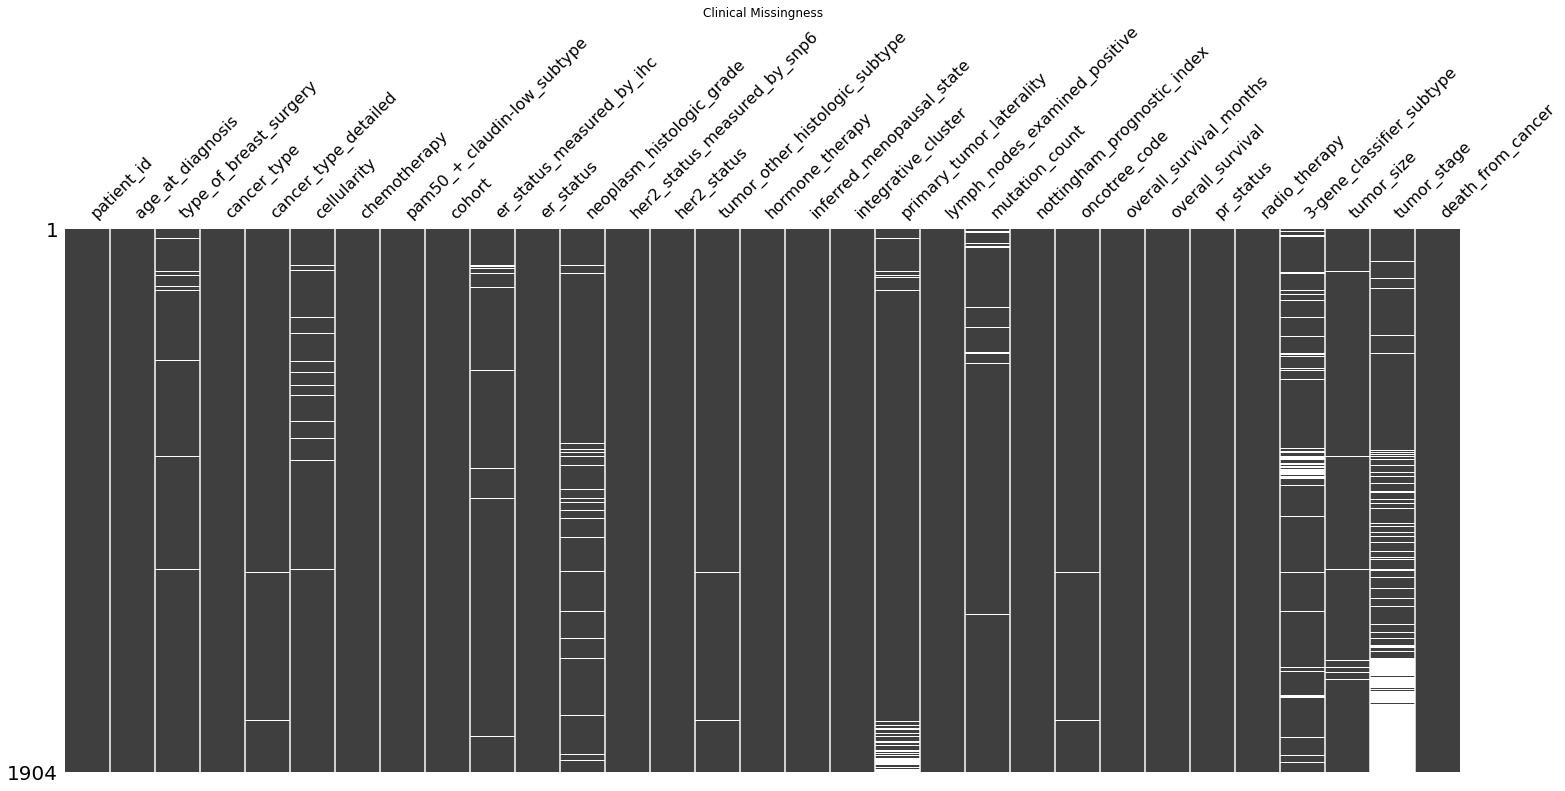

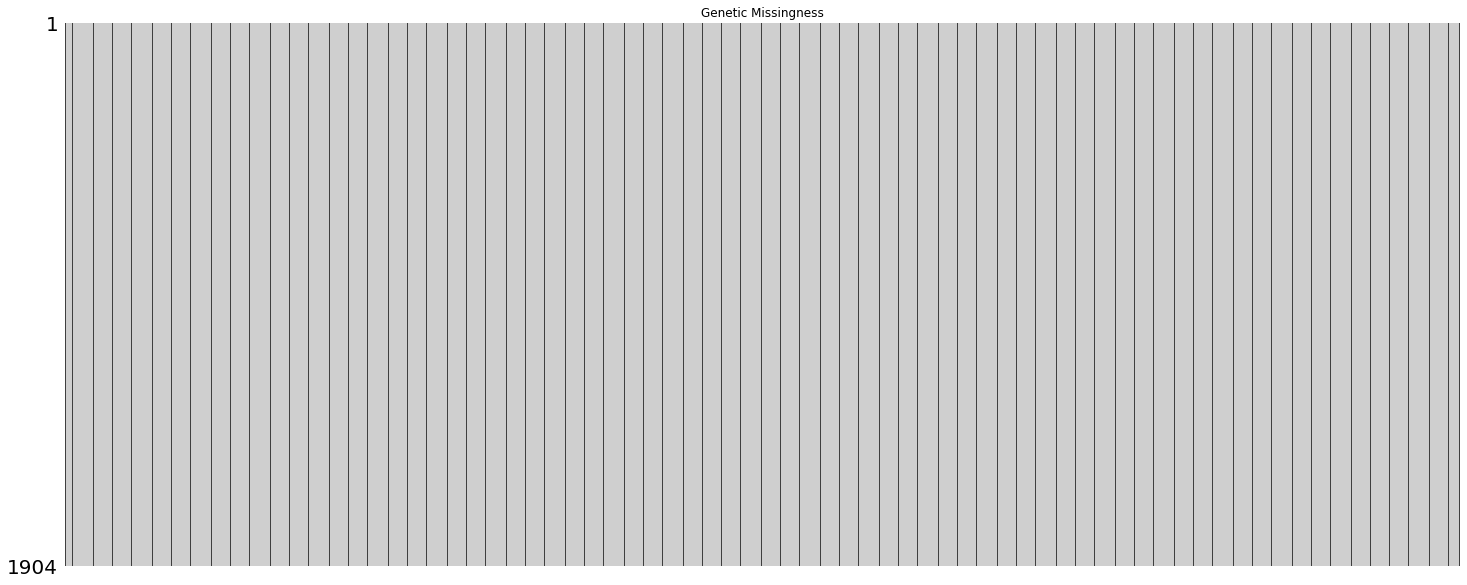

In [18]:
# Missingness
ax = msno.matrix(df.iloc[:,:31], sparkline=False)
plt.title('Clinical Missingness'); plt.show()
ax = msno.matrix(df.iloc[:,31:], sparkline=False)
plt.title('Genetic Missingness'); plt.show()

# Correlation of genetic data
There appears to be some correlation between variables in the genetic data. Given the large number of variables we may expect a number of spurious correlations. However, for that very same reason we should potentially look to reduce the dimensionality of this subset of the data.

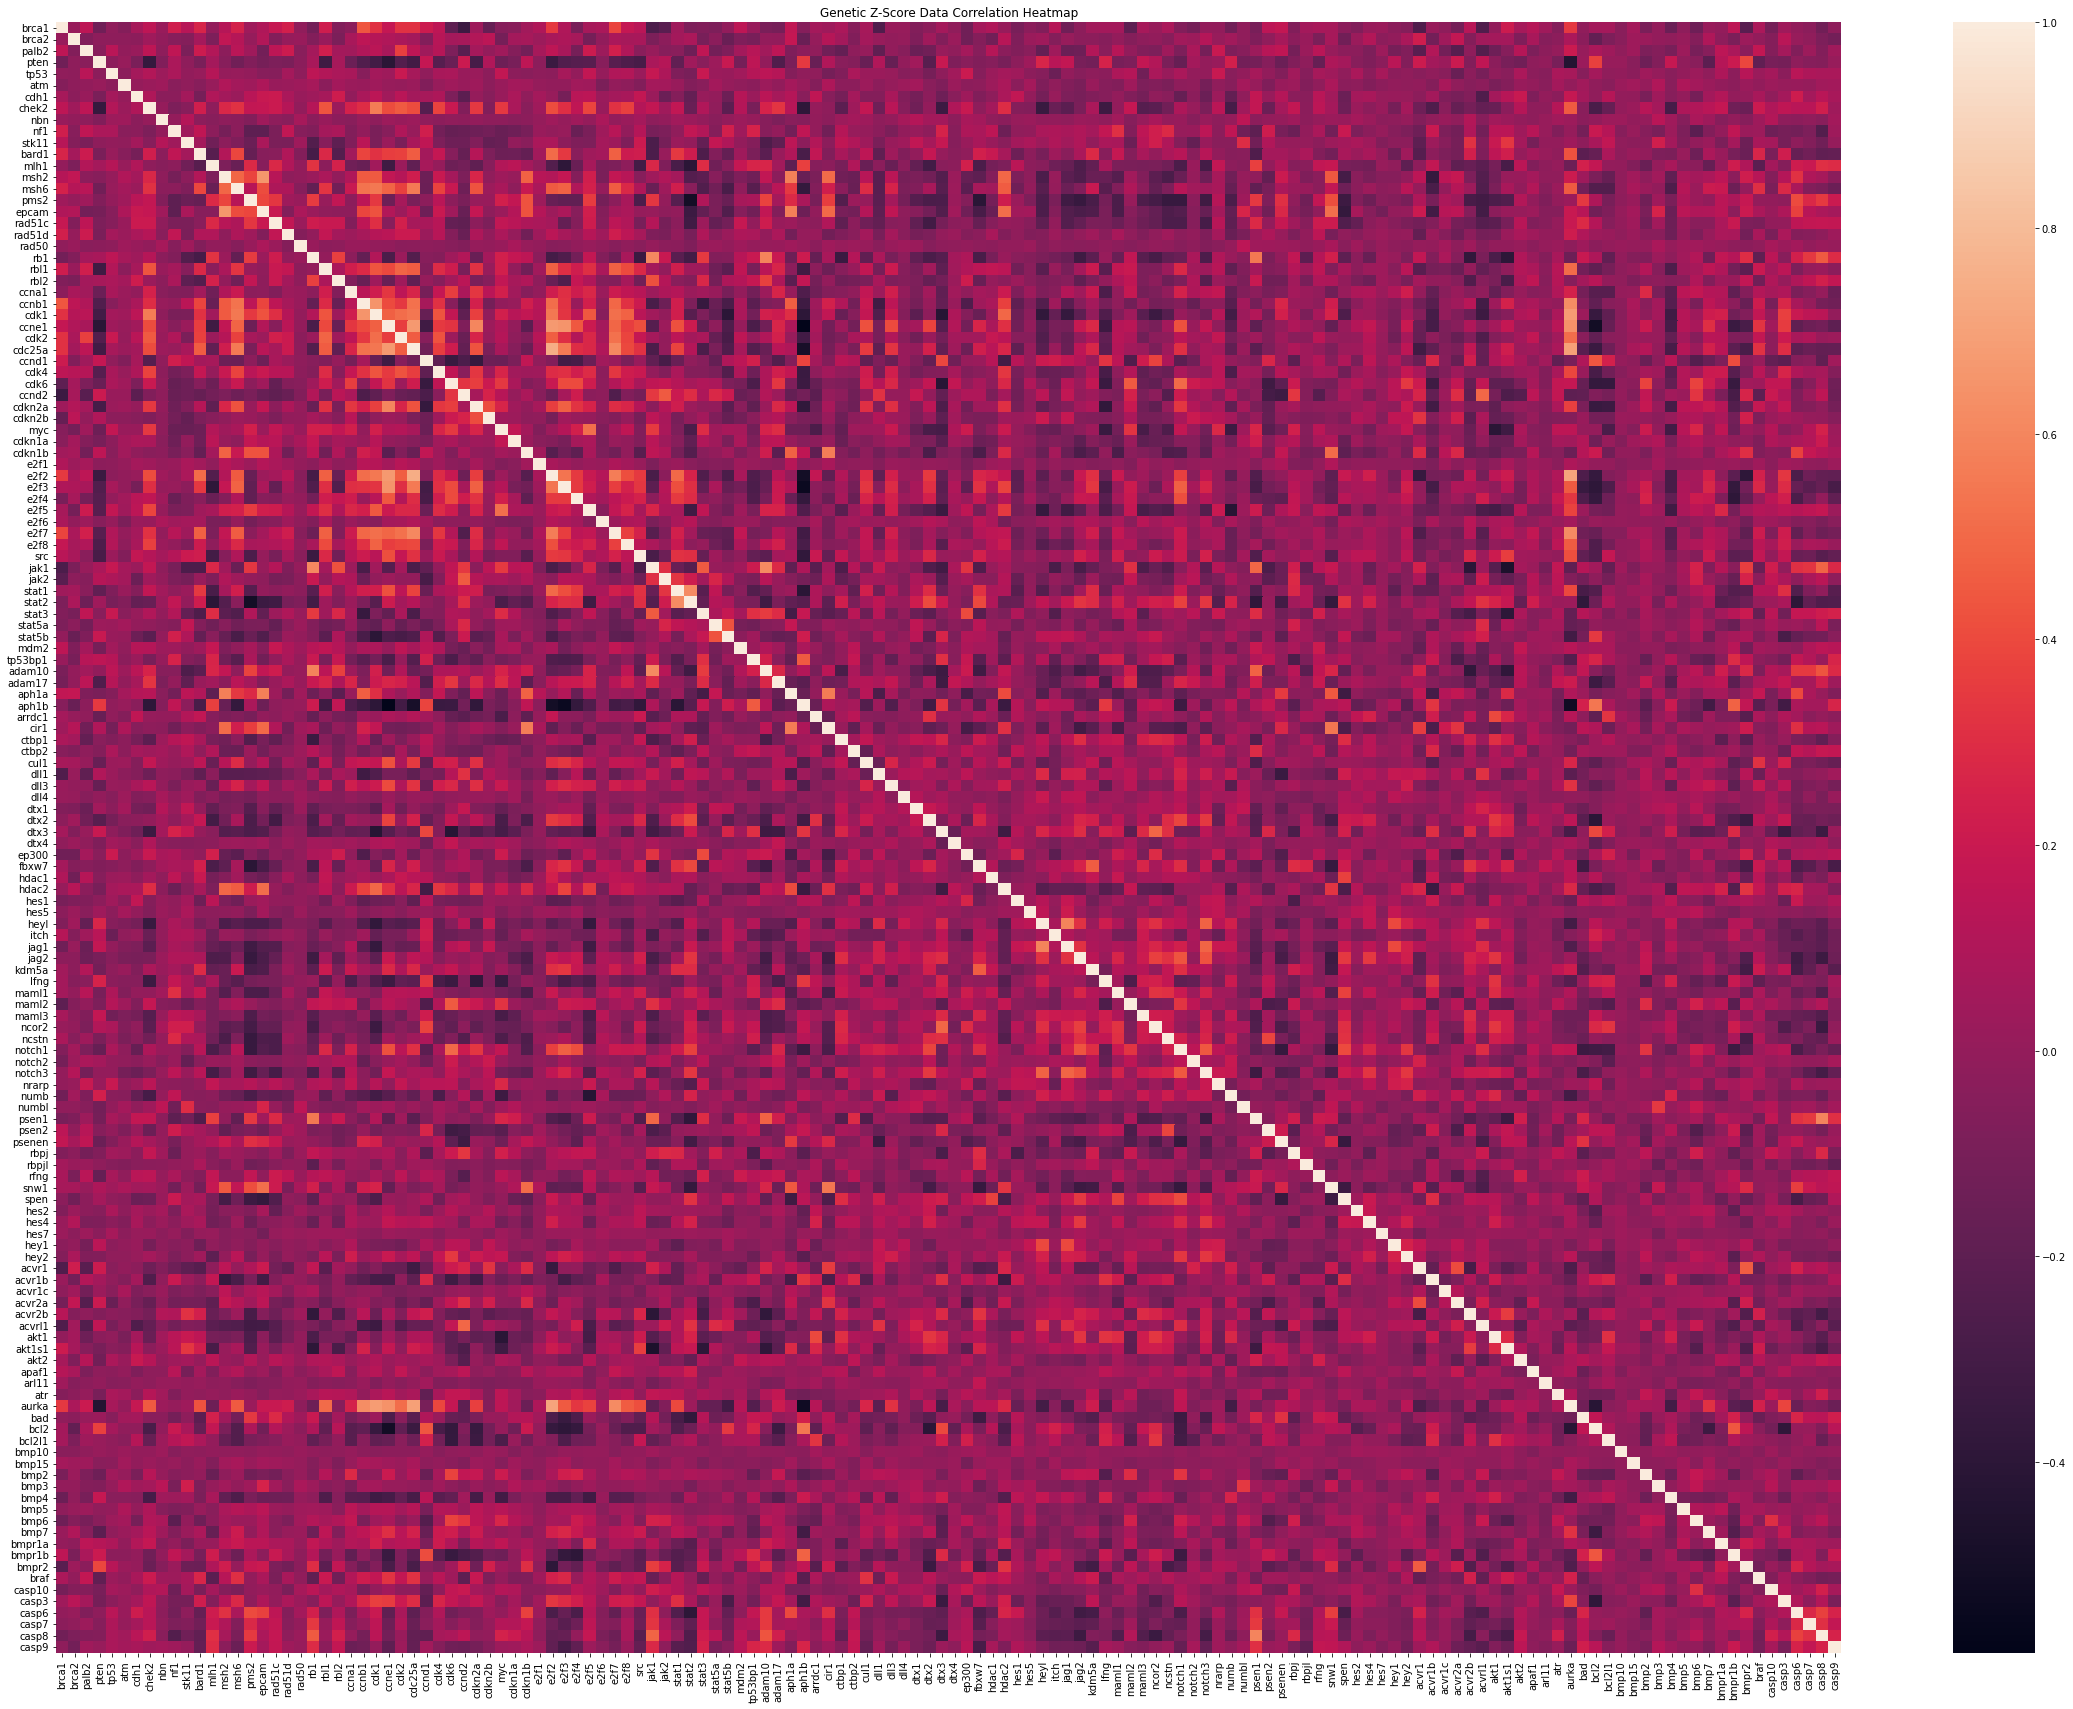

In [19]:
# Correlation between the z-scores for the genes
genedf = df.iloc[:,31:173]
corr = genedf.corr()
plt.figure(figsize=(40,30)); sns.heatmap(corr)
plt.title('Genetic Z-Score Data Correlation Heatmap'); plt.show()
# There looks to be some correlation between genes
# This should be accounted for with a PCA-type approach, 
# but I will instead just use a simple heuristic.


# Plan
Given that a large portion of this data is **right-censored**, it makes sense to use a survival analysis rather than a naive regression.

The best tool for this in Python is the **'lifelines'** package. This is a nice package with an API to interface with SKlearn but is somewhat limited in what it can do in terms of investigating non-linear interactions in the prediction variables. sklearn-survival provides another route to conducting this analysis, however in my expereince lifelines is more full featured and robust.

With the time available, this meant I only investigated the **Cox proportional hazard model** using cross-validation to optimise the regularisation. I deemed this trade-off worth it for the model to be more parsimonious and credible. I also know from previous discussions with other researchers that these are typically good models for survival in oncology.

As a nice consequence of choosing this model, we can predict the entire survival curve rather than just the most likely number of remaining years.

The metric I choose to use is the **'concordance_index'**, which is similar to the AUC curve of standard machine learning but used specifically for models of right-censored data. A good StackOverflow post on this metric is linked here: https://stats.stackexchange.com/questions/478294/how-the-concordance-index-is-calculated-in-cox-model-if-the-actual-event-times-a/478305#478305


# Data Transform
Given that the Cox proportional hazard model leverages a linear model at it's core, we should look to see whether our data is symetrically distributed. I assume that the genetic data is normalised (as these data are z-scores), but there are a number of clinical predictors that should be examined. 

In the below analysis, I observed that  mutation counts, tumor size and lymph_nodes_examined_positive should be log transformed as they are all skewed with long right-sided tails.

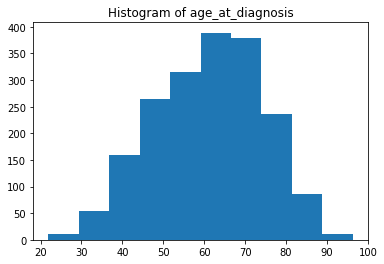

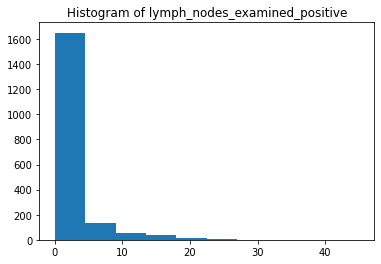

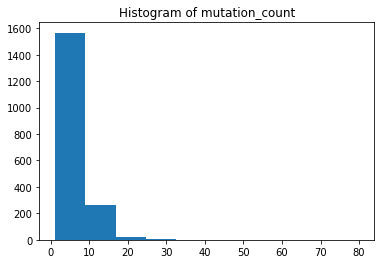

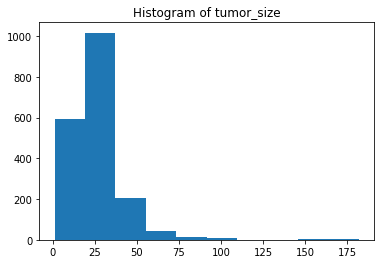

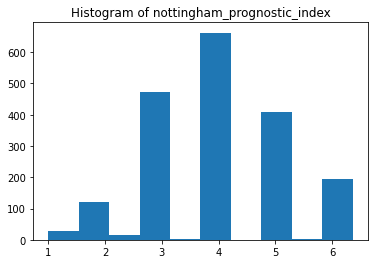

In [20]:
# Evaluate some of the data which my experience leads me to believe may be skewed
query_skewed = ['age_at_diagnosis','lymph_nodes_examined_positive','mutation_count','tumor_size','nottingham_prognostic_index']

for column in query_skewed:
  plt.hist(df[column])
  plt.title(f'Histogram of {column}')
  plt.show()



I now drop some clinical columns which inuitively are likely to be highly colinear with other columns or for which we could not reasonably collect data. 

I then removed some genetic data, inverted the outcome variable to be compatible with the lifelines package's expected format, applied the log-transform to the clinical data columns decribed above, and did a test/train split for future model validation. 

In [ ]:
# These columns are either likely to be highly colinear with other columns or would not be know a-priori
df.drop(columns = ['cancer_type',
                   'er_status_measured_by_ihc',
                   'her2_status_measured_by_snp6',
                   'death_from_cancer'], inplace=True )

# Ignoring the _mut columns, as these are very sparse and (probably) accounted for in number_of_mutations. 
df.drop(df.columns[-174:], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['type_of_breast_surgery',
                                         'cancer_type_detailed',
                                         'cellularity',
                                         'pam50_+_claudin-low_subtype',
                                         'cohort',
                                         'neoplasm_histologic_grade',
                                         'tumor_other_histologic_subtype',
                                         'integrative_cluster',
                                         'er_status',
                                         'inferred_menopausal_state',
                                         'her2_status',
                                         'primary_tumor_laterality',
                                         'oncotree_code',
                                         'pr_status',
                                         '3-gene_classifier_subtype'
                                         ],drop_first=True).astype('float')

                      

#Switich survival to died
df['died'] = 1 - df['overall_survival']
df.drop(columns= ['overall_survival'], inplace=True)


# Log transform right skewed columns
df['mutation_count'] = np.log(df['mutation_count']+1)
df['tumor_size'] = np.log(df['tumor_size'])
df['lymph_nodes_examined_positive'] = np.log(df['lymph_nodes_examined_positive']+1)


# Settting up test_train split and imputation based only on the train data

X = df.drop('overall_survival_months', axis=1) 
y = df['overall_survival_months'].astype('int')



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)


# I'm doing the imputation here rather than as part of a standard sklearn pipeline as the lifeline package sometimes doesn't interface well with sklearn pipelines.
# This could lead to overestimation of accuracy in cross validatation, but as we will conduct a final validation the test set so this should not be an issue
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

# Modelling
Following best practise, I will build four models.


1. A dummy model to provide a naive baseline where neither genetic nor clinical data are leveraged.
2. A model leveraging only genetic predictors.
3. A model leveraging only clinical predictors.
4. A model leveraging both genetic clinical predictors.


## The Dummy Model
The concordance score (our metric) is 0.5. This is correct, as the dummy model should always have a concordance score of 0.5 as it has no way of identifying which individuals should be expected to survive longest.

In [22]:
death_column = ['died']

In [23]:
dummy_cph = ll.CoxPHFitter()

combined_dummy_train = X_train[death_column].copy()

combined_dummy_train['overall_survival_months'] = y_train.copy()
combined_dummy_train


dummy_cph.fit(combined_dummy_train, duration_col='overall_survival_months', event_col='died', formula=None)
concordance_index = dummy_cph.score(combined_dummy_train,'concordance_index') # Should be 0.5
print(f' The concordance index for the combined model is {concordance_index}')

 The concordance index for the combined model is 0.5


# Genetic Only

In [24]:
genetic_columns = ['mutation_count',
                    'brca1','brca2', 'palb2', 'pten',
                    'tp53', 'atm', 'cdh1', 'chek2',
                    'nbn', 'nf1', 'stk11', 'bard1',
                    'mlh1', 'msh2', 'msh6', 'pms2',
                    'epcam', 'rad51c', 'rad51d', 'rad50',
                    'rb1', 'rbl1', 'rbl2', 'ccna1',
                    'ccnb1', 'cdk1', 'ccne1', 'cdk2',
                    'cdc25a', 'ccnd1', 'cdk4', 'cdk6',
                    'ccnd2', 'cdkn2a', 'cdkn2b', 'myc',
                    'cdkn1a', 'cdkn1b', 'e2f1', 'e2f2', 
                   'e2f3', 'e2f4', 'e2f5', 'e2f6', 'e2f7', 
                   'e2f8', 'src', 'jak1', 'jak2', 'stat1', 
                   'stat2', 'stat3', 'stat5a', 'stat5b',
                   'mdm2', 'tp53bp1', 'adam10', 'adam17', 
                   'aph1a', 'aph1b', 'arrdc1', 'cir1', 
                   'ctbp1', 'ctbp2', 'cul1', 'dll1', 
                   'dll3', 'dll4', 'dtx1', 'dtx2',
                   'dtx3', 'dtx4', 'ep300', 'fbxw7',
                   'hdac1', 'hdac2', 'hes1', 'hes5', 
                   'itch', 'jag1', 'jag2', 'kdm5a', 
                   'lfng', 'maml1', 'maml2', 'maml3', 
                   'ncor2', 'ncstn', 'notch1', 'notch2',
                   'notch3', 'nrarp', 'numb', 'numbl',
                   'psen1', 'psen2', 'psenen', 'rbpj',
                   'rbpjl', 'rfng', 'snw1', 'spen', 
                   'hes2', 'hes4', 'hes7', 'hey1', 
                   'hey2', 'acvr1', 'acvr1b', 'acvr1c',
                   'acvr2a', 'acvr2b', 'acvrl1', 'akt1',
                   'akt1s1', 'akt2', 'apaf1', 'arl11',
                   'atr', 'aurka', 'bad', 'bcl2',
                   'bcl2l1', 'bmp10', 'bmp15', 'bmp2', 
                   'bmp3', 'bmp4', 'bmp5', 'bmp6',
                   'bmp7', 'bmpr1a', 'bmpr1b', 'bmpr2',
                   'braf', 'casp10', 'casp3', 'casp6',
                   'casp7', 'casp8', 'casp9', 'chek1',
                   'csf1', 'csf1r', 'cxcl8', 'cxcr1', 
                   'cxcr2', 'diras3', 'dlec1', 'dph1', 
                   'egfr', 'eif4e', 'eif4ebp1', 'eif5a2',
                   'erbb2', 'erbb3', 'erbb4', 'fas',
                   'fgf1', 'fgfr1', 'folr1', 'folr2', 
                   'folr3', 'foxo1', 'foxo3', 'gdf11',
                    'gdf2', 'gsk3b', 'hif1a', 'hla-g',
                    'hras', 'igf1', 'igf1r', 'inha',
                    'inhba', 'inhbc', 'itgav', 'itgb3',
                   'izumo1r', 'kdr', 'kit', 'kras', 
                   'map2k1', 'map2k2', 'map2k3', 'map2k4', 
                   'map2k5', 'map3k1', 'map3k3', 'map3k4', 
                   'map3k5', 'mapk1', 'mapk12', 'mapk14', 
                   'mapk3', 'mapk4', 'mapk6', 'mapk7',
                   'mapk8', 'mapk9', 'mdc1', 'mlst8',
                   'mmp1', 'mmp10', 'mmp11', 'mmp12', 
                   'mmp13', 'mmp14', 'mmp15', 'mmp16',
                   'mmp17', 'mmp19', 'mmp2', 'mmp21',
                   'mmp23b', 'mmp24', 'mmp25', 'mmp26', 
                   'mmp27', 'mmp28', 'mmp3', 'mmp7', 
                   'mmp9', 'mtor', 'nfkb1', 'nfkb2',
                   'opcml', 'pdgfa', 'pdgfb', 'pdgfra', 
                   'pdgfrb', 'pdpk1', 'peg3', 'pik3ca', 
                   'pik3r1', 'pik3r2', 'plagl1', 'ptk2',
                   'rab25', 'rad51', 'raf1', 'rassf1', 
                   'rheb', 'rictor', 'rps6', 'rps6ka1', 
                   'rps6ka2', 'rps6kb1', 'rps6kb2', 'rptor', 
                   'slc19a1', 'smad1', 'smad2', 'smad3',
                   'smad4', 'smad5', 'smad6', 'smad7',
                   'smad9', 'sptbn1', 'terc', 'tert', 
                   'tgfb1', 'tgfb2', 'tgfb3', 'tgfbr1', 
                   'tgfbr2', 'tgfbr3', 'tsc1', 'tsc2', 
                   'vegfa', 'vegfb', 'wfdc2', 'wwox',
                   'zfyve9', 'arid1a', 'arid1b', 'cbfb',
                   'gata3', 'kmt2c', 'kmt2d', 'myh9',
                   'ncor1', 'pde4dip', 'ptprd', 'ros1',
                   'runx1', 'tbx3', 'abcb1', 'abcb11', 
                   'abcc1', 'abcc10', 'bbc3', 'bmf', 
                   'cyp2c8', 'cyp3a4', 'fgf2', 'fn1',
                   'map2', 'map4', 'mapt', 'nr1i2',
                   'slco1b3', 'tubb1', 'tubb4a', 'tubb4b', 
                   'twist1', 'adgra2', 'afdn', 'aff2',
                   'agmo', 'agtr2', 'ahnak', 'ahnak2', 
                   'akap9', 'alk', 'apc', 'arid2', 
                   'arid5b', 'asxl1', 'asxl2', 'bap1',
                   'bcas3', 'birc6', 'cacna2d3', 'ccnd3', 
                   'chd1', 'clk3', 'clrn2', 'col12a1',
                   'col22a1', 'col6a3', 'ctcf', 'ctnna1',
                   'ctnna3', 'dnah11', 'dnah2', 'dnah5',
                   'dtwd2', 'fam20c', 'fanca', 'fancd2',
                   'flt3', 'foxp1', 'frmd3', 'gh1',
                   'gldc', 'gpr32', 'gps2', 'hdac9',
                   'herc2', 'hist1h2bc', 'kdm3a', 'kdm6a', 
                   'klrg1', 'l1cam', 'lama2', 'lamb3', 
                   'large1', 'ldlrap1', 'lifr', 'lipi',
                   'magea8', 'map3k10', 'map3k13', 'men1', 
                   'mtap', 'muc16', 'myo1a', 'myo3a', 
                   'ncoa3', 'nek1', 'nf2', 'npnt', 
                   'nr2f1', 'nr3c1', 'nras', 'nrg3', 
                   'nt5e', 'or6a2', 'palld', 'pbrm1', 
                   'ppp2cb', 'ppp2r2a', 'prkacg', 'prkce',
                   'prkcq', 'prkcz', 'prkg1', 'prps2', 
                   'prr16', 'ptpn22', 'ptprm', 'rasgef1b',
                   'rpgr', 'ryr2', 'sbno1', 'setd1a',
                   'setd2', 'setdb1', 'sf3b1', 'sgcd',
                   'shank2', 'siah1', 'sik1', 'sik2',
                   'smarcb1', 'smarcc1', 'smarcc2', 'smarcd1',
                   'spaca1', 'stab2', 'stmn2', 'syne1',
                   'taf1', 'taf4b', 'tbl1xr1', 'tg', 
                   'thada', 'thsd7a', 'ttyh1', 'ubr5', 
                   'ush2a', 'usp9x', 'utrn', 'zfp36l1', 
                   'ackr3', 'akr1c1', 'akr1c2', 'akr1c3', 
                   'akr1c4', 'akt3', 'ar', 'bche',
                   'cdk8', 'cdkn2c', 'cyb5a', 'cyp11a1', 
                   'cyp11b2', 'cyp17a1', 'cyp19a1', 'cyp21a2',
                   'cyp3a43', 'cyp3a5', 'cyp3a7', 'ddc', 'hes6',
                   'hsd17b1', 'hsd17b10', 'hsd17b11', 'hsd17b12', 
                   'hsd17b13', 'hsd17b14', 'hsd17b2', 'hsd17b3', 
                   'hsd17b4', 'hsd17b6', 'hsd17b7', 'hsd17b8', 
                   'hsd3b1', 'hsd3b2', 'hsd3b7', 'mecom', 
                   'met', 'ncoa2', 'nrip1', 'pik3r3',
                   'prkci', 'prkd1', 'ran', 'rdh5', 
                   'sdc4', 'serpini1', 'shbg', 'slc29a1',
                   'sox9', 'spry2', 'srd5a1', 'srd5a2', 
                   'srd5a3', 'st7', 'star', 'tnk2', 
                   'tulp4', 'ugt2b15', 'ugt2b17' ]
geneticX_train= X_train[genetic_columns].copy()


# Rescaling mutation count
mean_mutations = X_train['mutation_count'].mean()
std_mutation = X_train['mutation_count'].std()

def scaler_mutationcount(mutation_count):
  return (mutation_count - mean_mutations)/std_mutation

geneticX_train['mutation_count'] = scaler_mutationcount(geneticX_train['mutation_count'])


In [25]:
# relevant_mutations

p_values_of_genetic = []

for column in genetic_columns:
  _,p = pearsonr(geneticX_train[column], X_train[death_column])
  p_values_of_genetic.append(p)



In [26]:
# As an approximation we limit to only a small number of predictors
number_of_genetic_predictors = 20
genetic_top_predictors = (pd.DataFrame({'column':genetic_columns, 'p_value': p_values_of_genetic}).
                          sort_values('p_value',ascending = True).
                          head(number_of_genetic_predictors)['column'].
                          to_list())
print(genetic_top_predictors)

geneticX_train = geneticX_train[genetic_top_predictors].copy()
geneticX_train['died'] = X_train[death_column]
geneticX_train


['hsd17b11', 'gsk3b', 'cdkn2c', 'jak1', 'spry2', 'kmt2c', 'tgfbr2', 'map4', 'pdgfra', 'tsc2', 'ccnd2', 'abcb1', 'lama2', 'smad4', 'jak2', 'tnk2', 'myc', 'casp8', 'pdgfb', 'kit']


,hsd17b11,gsk3b,cdkn2c,jak1,spry2,kmt2c,tgfbr2,map4,pdgfra,tsc2,...,abcb1,lama2,smad4,jak2,tnk2,myc,casp8,pdgfb,kit,died
764,0.8447,-0.2303,2.2512,0.6509,0.8574,0.1466,1.1513,-0.0544,0.6391,-0.2239,...,-0.0499,1.1955,-0.6099,0.3547,-0.5792,0.7334,1.3545,-0.8231,-0.1322,1.0
54,0.4549,1.4364,-0.6435,0.6027,2.5577,-0.2094,0.7095,0.1125,1.1115,-1.5434,...,-0.8666,-0.2817,0.4699,0.2886,-1.1213,0.4375,0.5626,0.5834,-0.2240,1.0
972,0.6706,3.2287,-0.4006,0.3842,-0.8245,1.6543,-0.1825,-0.6963,-0.3248,-0.4392,...,0.7687,-0.7790,-1.0319,0.1396,-0.7225,-1.7324,-1.0475,0.8811,-0.9861,0.0
882,-0.6454,2.7843,0.3670,-2.0607,1.3820,1.1717,-0.4486,0.2633,0.8301,-1.6941,...,-0.4696,-1.4810,-0.0709,-0.0074,-0.0905,-0.3744,-0.6427,2.9071,0.9169,1.0
320,1.9619,-1.1881,-0.9420,0.5931,0.6641,0.0210,-0.6445,0.1045,-0.1154,-0.6929,...,-0.1145,0.4997,-0.0252,-0.6697,-1.1677,-0.1586,0.5311,-0.2777,-0.2395,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,2.5652,0.7726,-0.7935,-0.1498,0.5587,1.3304,0.3957,0.4516,-0.4151,0.4896,...,-0.2003,-0.2642,-0.7599,-0.0547,-1.1053,-0.3561,-0.4895,1.1804,-0.8275,1.0
1346,-2.1635,0.9473,-1.0794,-3.1101,-0.7457,1.5309,-1.7949,2.9168,-1.0779,2.2338,...,-0.9419,-1.0746,-1.0613,-1.0672,2.4198,0.3175,-1.6840,-0.0565,0.4694,0.0
1406,0.1427,-0.3613,-0.1859,1.0538,-0.4092,-0.3917,0.5062,-0.0083,-0.4059,-0.6165,...,-0.9260,0.1703,-1.2899,-0.8157,0.0889,-0.8463,-1.0895,3.5487,-0.5145,0.0
1389,-0.4180,1.0302,-1.3431,0.7438,0.3424,1.5243,0.6734,1.1173,1.3236,-0.7063,...,1.3175,0.1208,-0.2311,0.7415,0.1332,-0.3258,-1.1135,1.0743,-0.1622,0.0


In [27]:
base_class = sklearn_adapter(ll.CoxPHFitter, event_col='died')
instantiated_base_class = base_class()

gscv = GridSearchCV(instantiated_base_class, {
   "penalizer": 10.0 ** np.arange(-2, 3),
   "l1_ratio": [0, 1/3, 2/3]
}, cv=5, verbose=0)
gscv.fit(geneticX_train, y_train)

print(gscv.best_estimator_)

SkLearnCoxPHFitter(baseline_estimation_method='breslow', breakpoints=None,
                   knots=None, l1_ratio=0.6666666666666666,
                   n_baseline_knots=None, penalizer=0.01, strata=None)


In [28]:
params_dict = gscv.best_estimator_.get_params()
genetic_cph = ll.CoxPHFitter(**params_dict)

combined_genetic_train = geneticX_train.copy()
combined_genetic_train['overall_survival_months'] = y_train


genetic_cph.fit(combined_genetic_train, duration_col='overall_survival_months', event_col='died', formula=None)

<lifelines.CoxPHFitter: fitted with 1618 total observations, 684 right-censored observations>

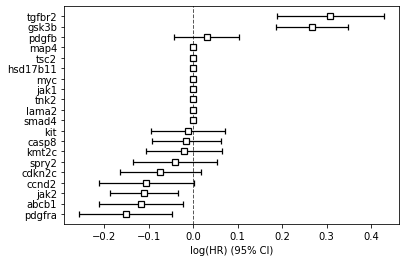

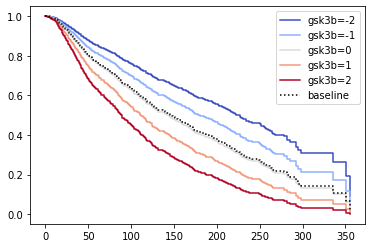

 The concordance index for the combined model is 0.6188849805461141


In [29]:
genetic_cph.plot(); plt.show()
genetic_cph.plot_partial_effects_on_outcome(covariates=['gsk3b'], values=[-2,-1,0,1,2], cmap='coolwarm'); plt.show()
concordance_index = genetic_cph.score(combined_genetic_train,'concordance_index')
print(f' The concordance index for the combined model is {concordance_index}')


# Clinical
I drop the columns for which data are binary and for which most of the data are the same. I then rescale the data to better enable regularisation.  

In [30]:
clinical_columns = [
    'chemotherapy','radio_therapy','hormone_therapy',
    'type_of_breast_surgery_MASTECTOMY',
    'cancer_type_detailed_Breast Invasive Ductal Carcinoma',
    'cancer_type_detailed_Breast Invasive Lobular Carcinoma',
    'cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma',
    'cancer_type_detailed_Breast Mixed Ductal and Lobular Carcinoma',
    'cancer_type_detailed_Metaplastic Breast Cancer','cellularity_Low',
    'cellularity_Moderate','pam50_+_claudin-low_subtype_Her2',
    'pam50_+_claudin-low_subtype_LumA','pam50_+_claudin-low_subtype_LumB',
    'pam50_+_claudin-low_subtype_NC','pam50_+_claudin-low_subtype_Normal',
    'pam50_+_claudin-low_subtype_claudin-low','cohort_2.0','cohort_3.0',
    'cohort_4.0','cohort_5.0','neoplasm_histologic_grade_2.0',
    'neoplasm_histologic_grade_3.0','tumor_other_histologic_subtype_Lobular',
    'tumor_other_histologic_subtype_Medullary',
    'tumor_other_histologic_subtype_Metaplastic',
    'tumor_other_histologic_subtype_Mixed',
    'tumor_other_histologic_subtype_Mucinous',
    'tumor_other_histologic_subtype_Other',
    'tumor_other_histologic_subtype_Tubular/ cribriform',
    'integrative_cluster_10','integrative_cluster_2','integrative_cluster_3',
    'integrative_cluster_4ER+','integrative_cluster_4ER-',
    'integrative_cluster_5','integrative_cluster_6','integrative_cluster_7',
    'integrative_cluster_8','integrative_cluster_9','er_status_Positive',
    'inferred_menopausal_state_Pre','her2_status_Positive',
    'primary_tumor_laterality_Right','oncotree_code_IDC','oncotree_code_ILC',
    'oncotree_code_IMMC','oncotree_code_MBC','oncotree_code_MDLC',
    'pr_status_Positive','3-gene_classifier_subtype_ER+/HER2- Low Prolif',
    '3-gene_classifier_subtype_ER-/HER2-','3-gene_classifier_subtype_HER2+'
 ]
clinicalX_train= X_train[clinical_columns].copy()



In [31]:
# remove columns with low variance
variance_threshold = 0.03

low_variance_columns = []

for column in clinical_columns:
  p = clinicalX_train[column].sum()/clinicalX_train[column].size
  var = p * (1-p)
  if var < variance_threshold:
    low_variance_columns.append(column)

clinicalX_train = clinicalX_train.drop(columns=low_variance_columns)

In [32]:
# Rescaling age count
mean_age = X_train['age_at_diagnosis'].mean()
std_age = X_train['age_at_diagnosis'].std()

def scaler_age(age_at_diagnosis):
  return (age_at_diagnosis - mean_age)/std_age

clinicalX_train['age_at_diagnosis'] = scaler_age(X_train['age_at_diagnosis'])


# Rescaling tumor_size
mean_tumor_size = X_train['tumor_size'].mean()
std_tumor_size = X_train['tumor_size'].std()

def scaler_tumor_size(tumor_size):
  return (tumor_size - mean_tumor_size)/std_tumor_size

clinicalX_train['tumor_size'] = scaler_tumor_size(X_train['tumor_size'])


# Rescaling lymph_nodes_examined_positive
mean_lymph_nodes_examined_positive = X_train['lymph_nodes_examined_positive'].mean()
std_lymph_nodes_examined_positive = X_train['lymph_nodes_examined_positive'].std()

def scaler_lymph_nodes_examined_positive(lymph_nodes_examined_positive):
  return (lymph_nodes_examined_positive - mean_lymph_nodes_examined_positive)/std_lymph_nodes_examined_positive

clinicalX_train['lymph_nodes_examined_positive'] = scaler_lymph_nodes_examined_positive(X_train['lymph_nodes_examined_positive'])


# Rescaling lymph_nodes_examined_positive
mean_nottingham_prognostic_index = X_train['nottingham_prognostic_index'].mean()
std_nottingham_prognostic_index = X_train['nottingham_prognostic_index'].std()

def scaler_nottingham_prognostic_index(nottingham_prognostic_index):
  return (nottingham_prognostic_index - mean_nottingham_prognostic_index)/std_nottingham_prognostic_index

clinicalX_train['nottingham_prognostic_index'] = scaler_nottingham_prognostic_index(X_train['nottingham_prognostic_index'])



# Rescaling tumor_stage
mean_tumor_stage = X_train['tumor_stage'].mean()
std_tumor_stage = X_train['tumor_stage'].std()

def scaler_tumor_stage(tumor_stage):
  return (tumor_stage - mean_tumor_stage)/std_tumor_stage

clinicalX_train['tumor_stage'] = scaler_tumor_size(X_train['tumor_stage'])



clinicalX_train['died'] = X_train[death_column]

In [33]:
gscv = GridSearchCV(instantiated_base_class, {
   "penalizer": 10.0 ** np.arange(-2, 3),
   "l1_ratio": [0, 1/3, 2/3]
}, cv=5, verbose=0)
gscv.fit(clinicalX_train, y_train)

print(gscv.best_estimator_)

SkLearnCoxPHFitter(baseline_estimation_method='breslow', breakpoints=None,
                   knots=None, l1_ratio=0.3333333333333333,
                   n_baseline_knots=None, penalizer=0.01, strata=None)


In [34]:
params_dict = gscv.best_estimator_.get_params()
clinical_cph = ll.CoxPHFitter(**params_dict)

combined_clinical_train = clinicalX_train.copy()
combined_clinical_train['overall_survival_months'] = y_train

clinical_cph.fit(combined_clinical_train, duration_col='overall_survival_months', event_col='died', formula=None, show_progress=True)

Iteration 1: norm_delta = 1.05114, step_size = 0.9500, log_lik = -6533.51025, newton_decrement = 247.88603, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.23252, step_size = 0.9500, log_lik = -6247.59806, newton_decrement = 9.56081, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.04149, step_size = 0.9500, log_lik = -6189.24187, newton_decrement = 0.16889, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.01383, step_size = 1.0000, log_lik = -6151.95047, newton_decrement = 0.00564, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.01522, step_size = 1.0000, log_lik = -6123.62695, newton_decrement = 0.00679, seconds_since_start = 0.3
Iteration 6: norm_delta = 0.01676, step_size = 0.9800, log_lik = -6102.09087, newton_decrement = 0.00871, seconds_since_start = 0.3
Iteration 7: norm_delta = 0.01774, step_size = 0.9604, log_lik = -6085.78208, newton_decrement = 0.01062, seconds_since_start = 0.4
Iteration 8: norm_delta = 0.01803, step_size = 0.9412, log_lik = -6073.494

<lifelines.CoxPHFitter: fitted with 1618 total observations, 684 right-censored observations>

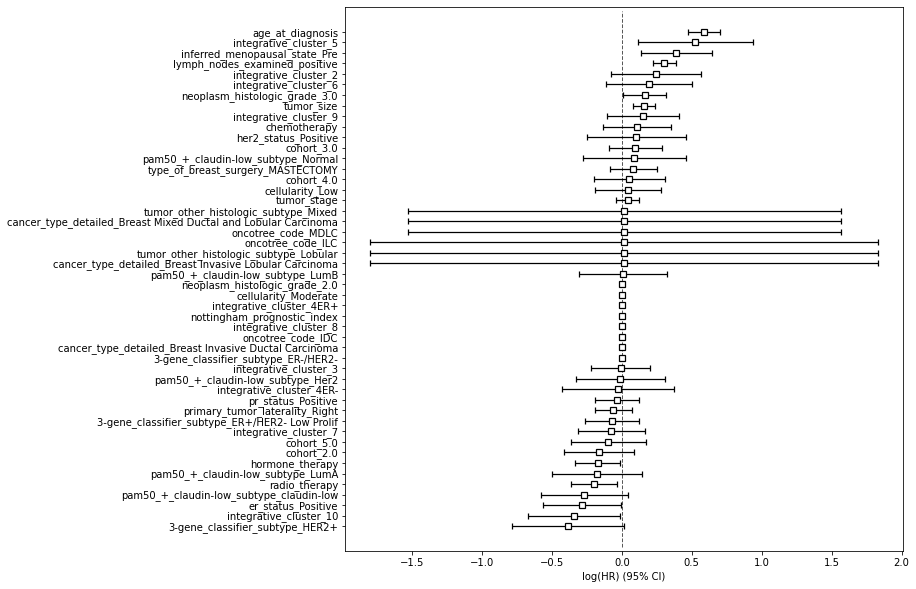

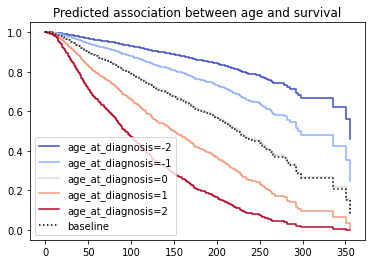

 The concordance index for the clinical-only model is 0.7008031863972106


In [43]:
fig = plt.figure(figsize=(10,10)); clinical_cph.plot(); plt.show()
clinical_cph.plot_partial_effects_on_outcome(covariates=['age_at_diagnosis'],
                                             values=[-2,-1,0,1,2],
                                             cmap='coolwarm')
plt.title('Predicted association between age and survival'); plt.show()
concordance_index = clinical_cph.score(combined_clinical_train,
                                       'concordance_index')
print(f' The concordance index for the clinical-only model is {concordance_index}')

# Both Clinical and Genetic
Here I used the transformed columns discussed above. 

In [36]:
combinedX_train= X_train[clinical_columns+genetic_top_predictors].copy()
combinedX_train = combinedX_train.drop(columns=low_variance_columns)
combinedX_train['age_at_diagnosis'] = scaler_age(X_train['age_at_diagnosis'])
combinedX_train['tumor_size'] = scaler_tumor_size(X_train['tumor_size'])
combinedX_train['lymph_nodes_examined_positive'] = scaler_lymph_nodes_examined_positive(X_train['lymph_nodes_examined_positive'])
combinedX_train['nottingham_prognostic_index'] = scaler_nottingham_prognostic_index(X_train['nottingham_prognostic_index'])
combinedX_train['tumor_stage'] = scaler_tumor_size(X_train['tumor_stage'])

if 'mutation_count' in genetic_top_predictors:
  combinedX_train['mutation_count'] = scaler_mutationcount(combinedX_train['mutation_count'])

combinedX_train['died'] = X_train[death_column]

In [37]:
gscv = GridSearchCV(instantiated_base_class, {
   "penalizer": 10.0 ** np.arange(-2, 3),
   "l1_ratio": [0, 1/3, 2/3]
}, cv=5, verbose=0)
gscv.fit(combinedX_train, y_train)

print(gscv.best_estimator_)

SkLearnCoxPHFitter(baseline_estimation_method='breslow', breakpoints=None,
                   knots=None, l1_ratio=0.6666666666666666,
                   n_baseline_knots=None, penalizer=0.01, strata=None)


In [38]:
params_dict = gscv.best_estimator_.get_params()
combined_cph = ll.CoxPHFitter(**params_dict)

combined_train = combinedX_train.copy()
combined_train['overall_survival_months'] = y_train

combined_cph.fit(combined_train, duration_col='overall_survival_months', event_col='died', formula=None, show_progress=True)

Iteration 1: norm_delta = 1.11405, step_size = 0.9500, log_lik = -7039.62855, newton_decrement = 276.07434, seconds_since_start = 0.2
Iteration 2: norm_delta = 0.25418, step_size = 0.9500, log_lik = -6609.73370, newton_decrement = 12.71018, seconds_since_start = 0.3
Iteration 3: norm_delta = 0.05569, step_size = 0.9500, log_lik = -6458.99584, newton_decrement = 0.28968, seconds_since_start = 0.5
Iteration 4: norm_delta = 0.02644, step_size = 1.0000, log_lik = -6353.30606, newton_decrement = 0.02504, seconds_since_start = 0.7
Iteration 5: norm_delta = 0.02741, step_size = 1.0000, log_lik = -6272.79539, newton_decrement = 0.03000, seconds_since_start = 0.8
Iteration 6: norm_delta = 0.02838, step_size = 0.9800, log_lik = -6211.49980, newton_decrement = 0.03765, seconds_since_start = 1.0
Iteration 7: norm_delta = 0.02845, step_size = 0.9604, log_lik = -6165.01747, newton_decrement = 0.04523, seconds_since_start = 1.2
Iteration 8: norm_delta = 0.02778, step_size = 0.9412, log_lik = -6129.94

<lifelines.CoxPHFitter: fitted with 1618 total observations, 684 right-censored observations>

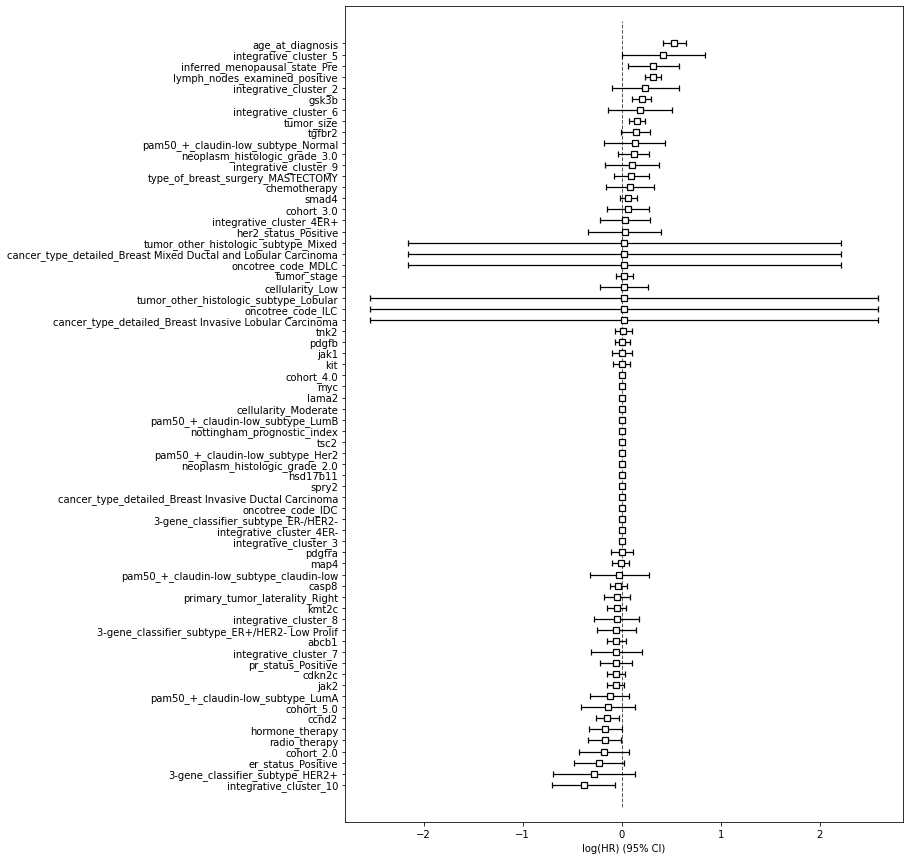

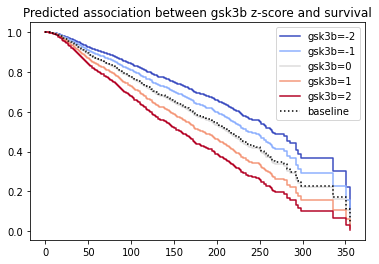

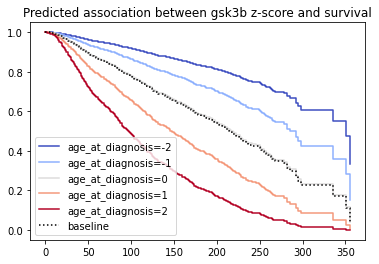

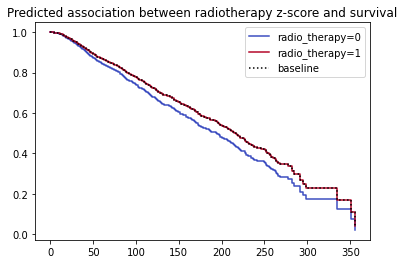

 The concordance index for the combined model is 0.7115719881607954


In [44]:
fig = plt.figure(figsize=(10,15)); combined_cph.plot(); plt.show()
combined_cph.plot_partial_effects_on_outcome(covariates=['gsk3b'],
                                             values=[-2,-1,0,1,2],
                                             cmap='coolwarm')
plt.title('Predicted association between gsk3b z-score and survival')
plt.show()
combined_cph.plot_partial_effects_on_outcome(covariates=['age_at_diagnosis'],
                                             values=[-2,-1,0,1,2],
                                             cmap='coolwarm')
plt.title('Predicted association between gsk3b z-score and survival')
plt.show()
combined_cph.plot_partial_effects_on_outcome(covariates=['radio_therapy'],
                                             values=[0,1],
                                             cmap='coolwarm')
plt.title('Predicted association between radiotherapy z-score and survival')
plt.show()
concordance_index = combined_cph.score(combined_train,'concordance_index')
print(f' The concordance index for the combined model is {concordance_index}')

# Validation of score on test set
Concordance was improve by ~ 1% when using both clinical and genetic data when compared to only using clinical data. Practically I am not convinced that this is a relevant improvement, but as this was our metric of choice I will carry this model on as the 'best' model in the validation. 

We observe some overfitting so I believe a sensible next step may be to increase regularisation or use more intelligent dimensionality reduction. 

In [49]:
combinedX_test= X_test[clinical_columns+genetic_top_predictors].copy()
combinedX_test = combinedX_test.drop(columns=low_variance_columns)
combinedX_test['age_at_diagnosis'] = scaler_age(X_test['age_at_diagnosis'])
combinedX_test['tumor_size'] = scaler_tumor_size(X_test['tumor_size'])
combinedX_test['lymph_nodes_examined_positive'] = scaler_lymph_nodes_examined_positive(X_test['lymph_nodes_examined_positive'])
combinedX_test['nottingham_prognostic_index'] = scaler_nottingham_prognostic_index(X_test['nottingham_prognostic_index'])
combinedX_test['tumor_stage'] = scaler_tumor_size(X_test['tumor_stage'])

if 'mutation_count' in genetic_top_predictors:
  combinedX_test['mutation_count'] = scaler_mutationcount(combinedX_test['mutation_count'])


combinedX_test['died'] = X_test[death_column]

combined_test = combinedX_test.copy()
combined_test['overall_survival_months'] = y_test

combined_val = combined_cph.score(combined_test,'concordance_index')
print(f'The validation concordance index for the combined model is {combined_val}')
dummy_val = dummy_cph.score(combined_test,'concordance_index')
print(f'The validation concordance index for the dummy model is {dummy_val}')

The validation concordance index for the combined model is 0.6470500540419664
The validation concordance index for the dummy model is 0.5


# Providing a prediction and explanation to a patient. 

The below function can be run to make a prediction for the survival of a patient. The function takes the path of a csv file of the same format of the original data, and a patient id to search for in that csv file. 

It outputs a personalised prediction for that individual and gives an explanation.

<ipython-input-41-c98bf3b80987>:78: DtypeWarning: Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.
  predictive_model('METABRIC_RNA_Mutation.csv', 0)


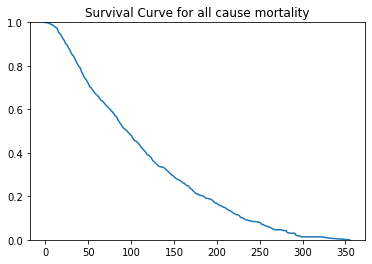

Predicted Median Survival Time: 96.0 months (= 8.0 years)
Because of your status for 'lymph_nodes_examined_positive', you have an Increased risk
Because of your status for 'age_at_diagnosis', you have an Increased risk
Because of your status for 'cdkn2c', you have a Decreased risk
Because of your status for 'tgfbr2', you have an Increased risk
Because of your status for 'er_status_Positive', you have a Decreased risk


In [41]:
def predictive_model(FILEPATH, patient_id):
  """
  A not-particuarly optimised function used to predict the survival curve for a patient with id 'patient_id' of a dataframe.
  This also outputs the factors that most impacted the prediction.
  """
  _df = pd.read_csv(FILEPATH)
  _df = _df[_df['patient_id'] == patient_id]
  _df = _df.replace(r'^\s*$', np.nan, regex=True)

  _df = pd.get_dummies(_df, columns=['type_of_breast_surgery',
                                         'cancer_type_detailed',
                                         'cellularity',
                                         'pam50_+_claudin-low_subtype',
                                         'cohort',
                                         'neoplasm_histologic_grade',
                                         'tumor_other_histologic_subtype',
                                         'integrative_cluster',
                                         'er_status',
                                         'inferred_menopausal_state',
                                         'her2_status',
                                         'primary_tumor_laterality',
                                         'oncotree_code',
                                         'pr_status',
                                         '3-gene_classifier_subtype'
                                         ],drop_first=False)
  _df = _df.reindex(columns = df.columns, fill_value=0).astype('float')

  # account for right_skew
  _df['mutation_count'] = np.log(_df['mutation_count']+1)
  _df['tumor_size'] = np.log(_df['tumor_size'])
  _df['lymph_nodes_examined_positive'] = np.log(_df['lymph_nodes_examined_positive']+1)

  # impute
  _df = _df.fillna(X_train.mean())
  _df = _df.fillna(X_train.mean())


  # select important columns
  combinedX= _df[clinical_columns+genetic_top_predictors]
  combinedX = combinedX.drop(columns=low_variance_columns)
  combinedX['age_at_diagnosis'] = scaler_age(_df['age_at_diagnosis'])
  combinedX['tumor_size'] = scaler_tumor_size(_df['tumor_size'])
  combinedX['lymph_nodes_examined_positive'] = scaler_lymph_nodes_examined_positive(_df['lymph_nodes_examined_positive'])
  combinedX['nottingham_prognostic_index'] = scaler_nottingham_prognostic_index(_df['nottingham_prognostic_index'])
  combinedX['tumor_stage'] = scaler_tumor_size(_df['tumor_stage'])

  if 'mutation_count' in genetic_top_predictors:
    combinedX['mutation_count'] = scaler_mutationcount(_df['mutation_count'])


  # Mortality prediction

  plt.plot(combined_cph.predict_survival_function(combinedX))
  plt.title('Survival Curve for all cause mortality')
  plt.ylim(0,1)
  plt.show()

  median_survival = combined_cph.predict_median(combinedX)
  print(f'Predicted Median Survival Time: {median_survival} months (={median_survival/12 : .1f} years)')



  # Calculate the most impactful covariates for this individuals
  impacts = []
  for covariate in combined_cph.params_.index:
    impact = combined_cph.params_[covariate] * combinedX[covariate].values[0]
    impacts.append(impact)
  impact_df = pd.DataFrame({'predictor': combined_cph.params_.index,
                          'impact': impacts,
                          'absolute_impact': np.abs(impacts)}).sort_values('absolute_impact',ascending = False).head(5)
  impact_df['Effect'] = np.where(impact_df['impact']>=0, 'an Increased risk', 'a Decreased risk')
  for index, row in impact_df.iterrows():
    predictor = row['predictor'] 
    effect = row['Effect']
    print(f'Because of your status for \'{predictor}\', you have {effect}')  

predictive_model('METABRIC_RNA_Mutation.csv', 0)


# Overall thoughts

In this work, I produced a model for predicting the survival curve of individuals with breast cancer. Both clinical and genetic features lead to improved concordance relative to a dummy baseline, though clinical features seemed most important based on this analysis. 

The models were explainable, in particular, I note: 

*   Increased age and the high values for gs3kb were associated with accelerated mortality.
*   Hormone therapy and radiotherapy were associated with decelerated mortality.

Despite being explainable, I would highly suggest that these should not be interpreted as causal. For example, whilst we may be willing to believe that hormone therapy reduces mortality, this analysis alone would not be sufficient evidence for that statement.


The logical next step would be to improve feature engineering. I used heuristics for feature selection and did not look to validate the thresholds that I used. If this work were to be further explored this would be a logical next step.Additionally, I did not spend time cleaning up the data transformation for the predictive model function, so if the formatting of the csv file were to change this function would no longer work as intended. 

Further, there could be improvements to be gained by updating the model such that the CoxPH assumptions are better fulfilled. Below I've run the 'check_assumptions' function, which shows that this might be the case. With that said, this model tends to be reasonably robust regarding modelling assumptions, and addressing this issue would take time which was not available. The visual plots produced when checking these assumptions also do not look that bad.  

With that in mind, I believe that this modelling analysis produced a model that could be of prognostic interest to individuals with breast cancer. 

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1618 total observations, 684 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                     test_statistic      p  -log2(p)
3-gene_classifier_subtype_ER+/HER2- Low Prolif                 km              2.21   0.14      2.87
                                                               rank            1.89   0.17      2.57
3-gene_classifier_subtype_ER-/HER2-                            km              0.00   1.00      0.00
                                                               rank            0.00   1.00      0.00
3-gene_classifier_subtype_HER2+                                km              0.13   0.71      0.49
                                                               rank            0.22   0.64      0.65
abcb1                                                          km              0.42   0.52      0.95
                                                               rank            0.61   0.43      1.21
age_at_diagnosis                                               km              9.13 <0.005      8.64
                                                               rank            9.27 <0.005      8.75
cancer_type_detailed_Breast Invasive Ductal Carcinoma          km              0.00   1.00      0.00
                                                               rank            0.00   1.00      0.00
cancer_type_detailed_Breast Invasive Lobular Carcinoma         km              0.00   0.99      0.02
                                                               rank            0.00   0.99      0.01
cancer_type_detailed_Breast Mixed Ductal and Lobular Carcinoma km              0.00   0.95      0.07
                                                               rank            0.00   0.95      0.07
casp8                                                          km              0.14   0.71      0.50
                                                               rank            0.10   0.75      0.41
ccnd2                                                          km              1.10   0.29      1.77
                                                               rank            1.33   0.25      2.01
cdkn2c                                                         km              0.12   0.73      0.46
                                                               rank            0.19   0.67      0.59
cellularity_Low                                                km              0.19   0.66      0.60
                                                               rank            0.14   0.71      0.50
cellularity_Moderate                                           km              0.00   1.00      0.01
                                                               rank            0.00   1.00      0.01
chemotherapy                                                   km              0.20   0.66      0.60
                                                               rank            0.24   0.62      0.68
cohort_2.0                                                     km              8.01 <0.005      7.75
                                                               rank            8.57 <0.005      8.20
cohort_3.0                                                     km              0.48   0.49      1.03
                                                               rank            0.49   0.48      1.05
cohort_4.0                                                     km              0.00   0.99      0.01
                                                               rank            0.00   1.00      0.01
cohort_5.0                                                     km              4.16   0.04      4.59
                                                               rank            4.53   



1. Variable 'hormone_therapy' failed the non-proportional test: p-value is 0.0027.

   Advice: with so few unique values (only 2), you can include `strata=['hormone_therapy', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'cohort_2.0' failed the non-proportional test: p-value is 0.0034.

   Advice: with so few unique values (only 2), you can include `strata=['cohort_2.0', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'age_at_diagnosis' failed the non-proportional test: p-value is 0.0023.

   Advice 1: the functional form of the variable 'age_at_diagnosis' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 

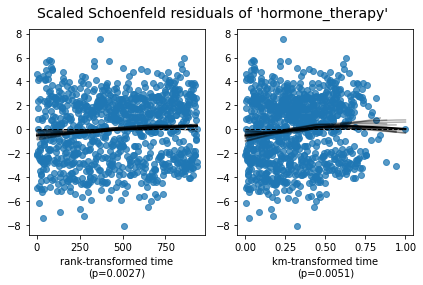

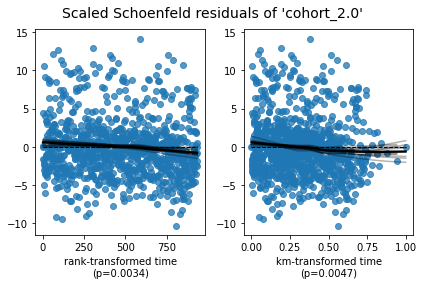

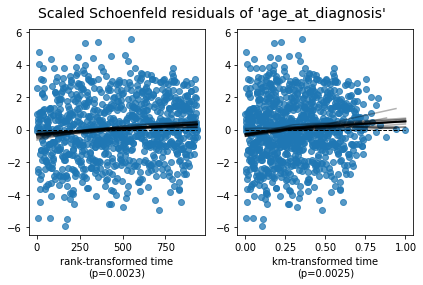

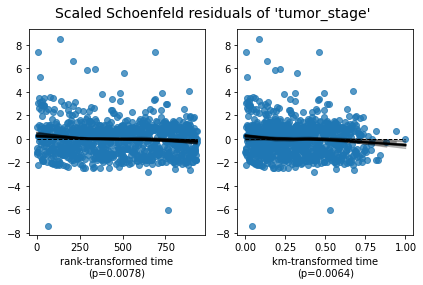

In [42]:
# Potential for improvements based on modelling assumptions
combined_cph.check_assumptions(combined_train, show_plots=True)
plt.show()